In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sea

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

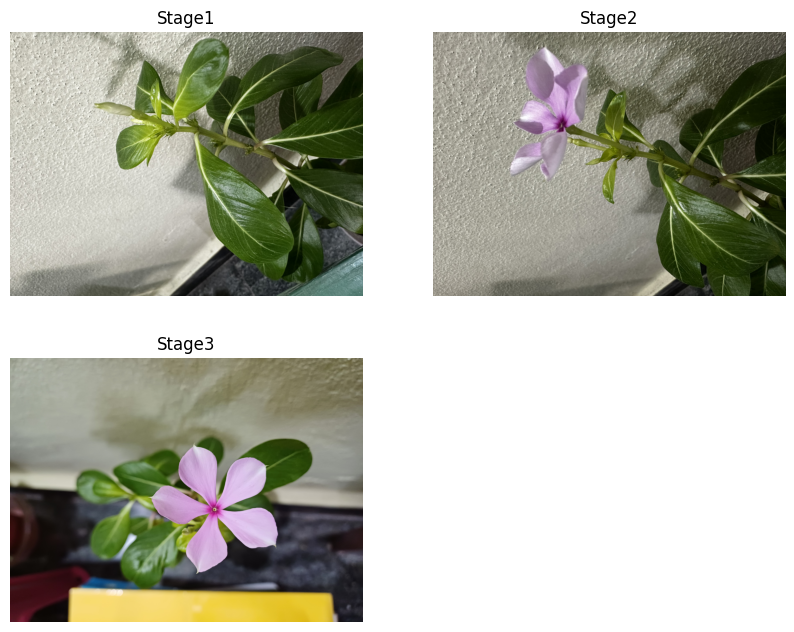

In [2]:
classes = [ "Stage1", "Stage2", "Stage3"]
path = "/content/drive/MyDrive/Flowerdata/Classification"

file_path = [#os.path.join(path, "Stage1/20230803_120514.jpg"),
             os.path.join(path, "Stage1/IMG_0157.JPG"),
             #os.path.join(path, "Stage2/20230804_020548.jpg"),
             os.path.join(path, "Stage2/IMG_0254.JPG"),
             os.path.join(path, "Stage3/20230805_195123.jpg")]

fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig)

for i in range(3):
    y, x = i//2, i%2
    ax = fig.add_subplot(gs[y,x])
    ax.imshow(image.load_img(file_path[i]))
    ax.axis("off")
    ax.title.set_text(classes[i])

# using mobileNet for feature extracting

In [3]:
# load pretrained MobileNet
model = MobileNet(input_shape=(224,224,3), include_top=True)

model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

#### The output of reshape_2 layer is a 1000 elements vector. MobileNet predictions layer takes this vector as input. We use this vector as our feature and try to do classification.

# A new model feature_extractor is created

In [4]:
vector = model.get_layer("reshape_2").output
feature_extractor = tf.keras.Model(model.input, vector)

In [5]:
# create empty feature and label lists
X_list = []
Y_list = []

for f in range(3):
    folder_path = os.path.join(path, classes[f])
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        # check file extension, skip file if not jpg
        if not(file.endswith(".jpg")or file.endswith("JPG")):
            continue

        # load image
        img = image.load_img(file_path, target_size=(224, 224))
        # convert image to numpy array
        img_arr = image.img_to_array(img)
        # add 1 more dimension
        img_arr_b = np.expand_dims(img_arr, axis=0)
        # preprocess image
        input_img = preprocess_input(img_arr_b)
        # extract feature
        feature_vec = feature_extractor.predict(input_img)

        X_list.append(feature_vec.ravel())

        # Modify the class assignment
        if f == 0:
            Y_list.append(0)  # Stage 1
        elif f == 1:
            Y_list.append(1)  # Stage 2
        else:
            Y_list.append(2)  # Stage 3



1/1 [==============================] - 0s 26ms/step


In [6]:
X = np.asarray(X_list, dtype=np.float32)
Y = np.asarray(Y_list, dtype=np.float32)

for s in range(100):
    X, Y = shuffle(X, Y)

print("Shape of feature matrix X")
print(X.shape)
print("\nShape of label matrix Y")
print(Y.shape)

class_types, counts = np.unique(Y, return_counts=True)

print("\nClass labels")
print(class_types)
print("\nClass counts")
print(counts)

Shape of feature matrix X
(297, 1000)

Shape of label matrix Y
(297,)

Class labels
[0. 1. 2.]

Class counts
[150  81  66]


# Split Data

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=0)

print("Shape of train_X")
print(train_X.shape)
print("\nShape of test_X")
print(test_X.shape)

Shape of train_X
(237, 1000)

Shape of test_X
(60, 1000)


# SVM with Linear Kernel

In [8]:
svm_lin = svm.SVC(C=1.0, kernel="linear")
svm_lin.fit(train_X, train_Y)
y_pred = svm_lin.predict(test_X)
print(classification_report(test_Y, y_pred,
                            target_names=classes))

              precision    recall  f1-score   support

      Stage1       0.97      0.97      0.97        30
      Stage2       0.89      0.94      0.91        17
      Stage3       1.00      0.92      0.96        13

    accuracy                           0.95        60
   macro avg       0.95      0.94      0.95        60
weighted avg       0.95      0.95      0.95        60



In [9]:
svm_nlin = svm.SVC(C=1.0, kernel="rbf")
svm_nlin.fit(train_X, train_Y)
y_pred = svm_nlin.predict(test_X)
print(classification_report(test_Y, y_pred,
                            target_names=classes))

              precision    recall  f1-score   support

      Stage1       0.94      0.97      0.95        30
      Stage2       0.79      0.88      0.83        17
      Stage3       1.00      0.77      0.87        13

    accuracy                           0.90        60
   macro avg       0.91      0.87      0.88        60
weighted avg       0.91      0.90      0.90        60



In [13]:
y_pred = np.argmax(model.predict(test_X), axis=-1);
print(classification_report(test_Y, y_pred,
                            target_names=classes))

2/2 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Stage1       0.97      0.97      0.97        30
      Stage2       0.84      0.94      0.89        17
      Stage3       1.00      0.85      0.92        13

    accuracy                           0.93        60
   macro avg       0.94      0.92      0.92        60
weighted avg       0.94      0.93      0.93        60



In [14]:
# Load and preprocess the new image
new_img = image.load_img('/content/online2.jpg', target_size=(224, 224))
new_img_arr = image.img_to_array(new_img)
new_img_arr_b = np.expand_dims(new_img_arr, axis=0)
new_input_img = preprocess_input(new_img_arr_b)

# Extract features from the preprocessed image
new_feature_vec = feature_extractor.predict(new_input_img)

# Flatten the feature vector
new_flattened_feature = new_feature_vec.ravel()

# Make predictions using the trained model
predictions = model.predict(np.array([new_flattened_feature]))

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the predicted class
print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 19ms/step
Predicted class: 2


1/1 [==============================] - 0s 81ms/step
predicted_class: 2
Predicted class: Stage3
Predicted probabilities: [[0.93004984 0.04969615 2.6904664 ]]
Correct prediction: True


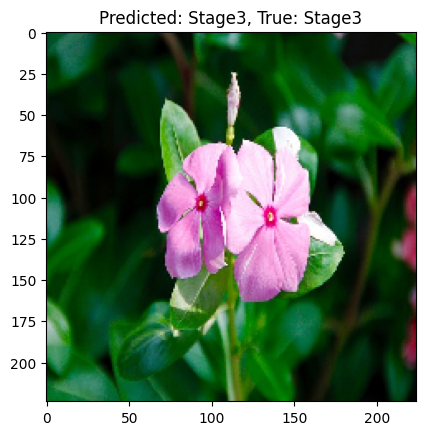

In [16]:
# Load and preprocess the new image
new_img = image.load_img('/content/online2.jpg', target_size=(224, 224))
new_img_arr = image.img_to_array(new_img)
new_img_arr_b = np.expand_dims(new_img_arr, axis=0)
new_input_img = preprocess_input(new_img_arr_b)

# Extract features from the preprocessed image
new_feature_vec = feature_extractor.predict(new_input_img)

# Flatten the feature vector
new_flattened_feature = new_feature_vec.ravel()

# Make predictions using the trained model
predictions = model.predict(np.array([new_flattened_feature]))

# Get the predicted class and corresponding label
predicted_class = np.argmax(predictions)
class_label = classes[predicted_class]
print("predicted_class:",predicted_class)
# Print the predicted class
print("Predicted class:", class_label)

# Print the predicted class probabilities
print("Predicted probabilities:", predictions)

# Get the true class label based on the filename (you need to modify this)
true_class = "Stage3"  # Replace with the true class label of the new image

# Check if the prediction is correct
correct_prediction = true_class == class_label
print("Correct prediction:", correct_prediction)

# Display the new image
plt.imshow(new_img)
plt.title(f"Predicted: {class_label}, True: {true_class}")
plt.show()


1/1 [==============================] - 0s 25ms/step
Predicted class: Stage1
Predicted probabilities: [[ 5.9474683  -0.43234912 -2.3167276 ]]
Correct prediction: True


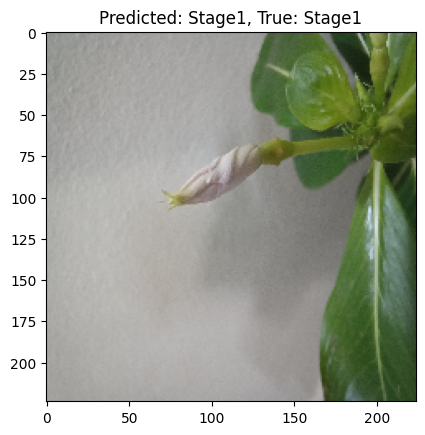

In [20]:
# Load and preprocess the new image
new_img = image.load_img('/content/20230803_113507.jpg', target_size=(224, 224))
new_img_arr = image.img_to_array(new_img)
new_img_arr_b = np.expand_dims(new_img_arr, axis=0)
new_input_img = preprocess_input(new_img_arr_b)

# Extract features from the preprocessed image
new_feature_vec = feature_extractor.predict(new_input_img)

# Flatten the feature vector
new_flattened_feature = new_feature_vec.ravel()

# Make predictions using the trained model
predictions = model.predict(np.array([new_flattened_feature]))

# Get the predicted class and corresponding label
predicted_class = np.argmax(predictions)
class_label = classes[predicted_class]

# Print the predicted class
print("Predicted class:", class_label)

# Print the predicted class probabilities
print("Predicted probabilities:", predictions)


true_class = "Stage1"  # Replace with the true class label of the new image

# Check if the prediction is correct
correct_prediction = true_class == class_label
print("Correct prediction:", correct_prediction)

# Display the new image
plt.imshow(new_img)
plt.title(f"Predicted: {class_label}, True: {true_class}")
plt.show()
